In [1]:
%load_ext lab_black
%load_ext autotime

import drnb.embed.pipeline as pl

time: 7.68 s (started: 2022-11-26 18:21:42 -08:00)


# Heavy-tailed UMAP

[Kobak and co-workers](https://arxiv.org/abs/1902.05804) define a heavy-tailed kernel for t-SNE as:

$$
w_{ij} = 1/\left(1 + \frac{1}{\alpha} d_{ij}^2\right)^\alpha
$$

$\alpha = 1$ gives the usual t-SNE Cauchy kernel. $\alpha < 1$ gives a progressively heavier tail which can reveal finer structure. $\alpha > 1$ gives a less heavy tail approaching the Gaussian as $\alpha \to \infty$.

The `htumap` embedder combines this kernel with UMAP (hijacking the `a` parameter to use to specify the heavy-tail parameter $\alpha$).

For deriving the gradient, here are some derivatives:

$$
\frac{\partial{d_{ij}^2}}{\partial{\mathbf{y_i}}} = 2 \left(\mathbf{y_i} - \mathbf{y_j}\right)
$$

$$
\frac{\partial{w_{ij}}}{\partial{d_{ij}^2}} = -w_{ij}^{\left(\alpha + 1 \right) / \alpha}
$$

The effective cost function for the attractive part of UMAP is:

$$
C_{\mathrm{UMAP}}^+ = \log w_{ij}
$$

$$
\frac{\partial{C_{\mathrm{UMAP}}^+}}{\partial{w_{ij}}} = -\frac{1}{w_{ij}}
$$

giving the gradient:

$$
\frac{\partial{C_{\mathrm{UMAP}}^+}}{\partial{\mathbf{y_i}}} = 2 w_{ij}^{1/\alpha}\left(\mathbf{y_i} - \mathbf{y_j}\right)
$$

For the repulsive part of the cost:

$$
C_{\mathrm{UMAP}}^- = \log \frac{1}{1-w_{ij}} = -\log \left(1 - w_{ij}\right)
$$

$$
\frac{\partial{C_{\mathrm{UMAP}}^-}}{\partial{w_{ij}}} = \frac{1}{1-w_{ij}}
$$

giving the gradient:

$$
\frac{\partial{C_{\mathrm{UMAP}}^-}}{\partial{\mathbf{y_i}}} =  \frac{-2w_{ij}^{\left(\alpha + 1 \right) / \alpha}}{1 - w_{ij}}\left(\mathbf{y_i} - \mathbf{y_j}\right)
$$

## Adding a precision

In the same way a Gaussian can have a bandwidth/precision parameter to control its width, you can do the same for the heavy-tailed kernel:

$$
w_{ij} = 1/\left(1 + \frac{\beta}{\alpha} d_{ij}^2\right)^\alpha \\
\frac{\partial{w_{ij}}}{\partial{d_{ij}^2}} = -\beta w_{ij}^{\left(\alpha + 1 \right) / \alpha}
$$

The gradients then become:

$$
\frac{\partial{C_{\mathrm{UMAP}}^+}}{\partial{\mathbf{y_i}}} = 2 \beta w_{ij}^{1/\alpha}\left(\mathbf{y_i} - \mathbf{y_j}\right) \\
\frac{\partial{C_{\mathrm{UMAP}}^-}}{\partial{\mathbf{y_i}}} =  \frac{-2 \beta w_{ij}^{\left(\alpha + 1 \right) / \alpha}}{1 - w_{ij}}\left(\mathbf{y_i} - \mathbf{y_j}\right)
$$

This doesn't have any practical value unless you allow the precision to vary per point, e.g. to reflect the original density of the data.

## Heavy-tailed Neg-UMAP

The (potentially) more numerically stable version of UMAP with a heavy-tailed kernel would look like:

$$
C_{\mathrm{negUMAP}}^+ = \log \left( \frac{w_{ij}}{\gamma + w_{ij}} \right) \\
\frac{\partial{C_{\mathrm{negUMAP}}^+}}{\partial{w_{ij}}} = -\frac{\gamma}{w_{ij} \left(\gamma + w_{ij}\right)} \\
C_{\mathrm{negUMAP}}^- = \log \left( \frac{1}{\gamma + w_{ij}} \right) \\
\frac{\partial{C_{\mathrm{negUMAP}}^-}}{\partial{w_{ij}}} = \frac{1}{\gamma + w_{ij}}
$$

leading to these gradients:

$$
\frac{\partial{C_{\mathrm{negUMAP}}^+}}{\partial{\mathbf{y_i}}} = \frac{2 \gamma \beta w_{ij}^{1/\alpha}}{\gamma + w_{ij}} \left(\mathbf{y_i} - \mathbf{y_j}\right)\\
\frac{\partial{C_{\mathrm{negUMAP}}^-}}{\partial{\mathbf{y_i}}} =  \frac{-2 \beta w_{ij}^{\left(\alpha + 1 \right) / \alpha}}{\gamma + w_{ij}}\left(\mathbf{y_i} - \mathbf{y_j}\right)
$$

`a=1` is $\alpha=1$ and should give the standard Cauchy results with UMAP (i.e. t-UMAP):

[18:54:34] INFO     Loading faiss with AVX2 support.                                                   ]8;id=747650;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=437976;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=993906;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=21743;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=132049;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=846496;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

[18:54:35] INFO     Successfully loaded faiss.                                                         ]8;id=594583;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=340801;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

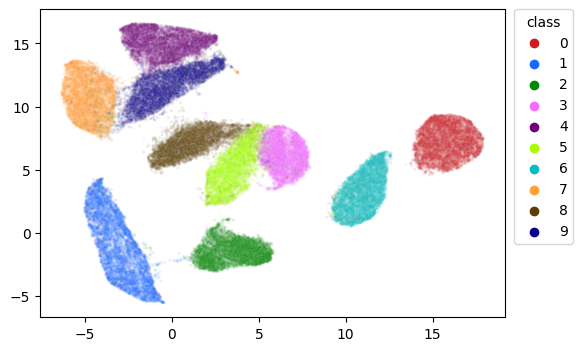

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6141000000000001, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.3503556459148912, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.10751523809523808, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.17224142857142857, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2595566666666667, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 35.2 s (started: 2022-11-26 18:54:07 -08:00)


In [2]:
pl.standard_eval(method="htumap", params=dict(a=1, b=1), dataset="mnist")

Here's a result with a heavier tail:

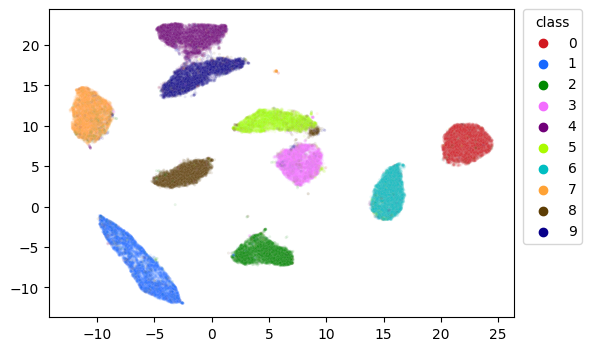

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6079057142857143, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.3223303014253377, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.12442761904761904, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.18752028571428572, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.27127533333333337, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 31.2 s (started: 2022-11-26 18:55:13 -08:00)


In [4]:
pl.standard_eval(method="htumap", params=dict(a=0.5, b=1), dataset="mnist")

Note that some of the 8 cluster has got stuck with the 5 cluster (and some of the 5 is stuck with the three). Initializing with the UMAP result should help:

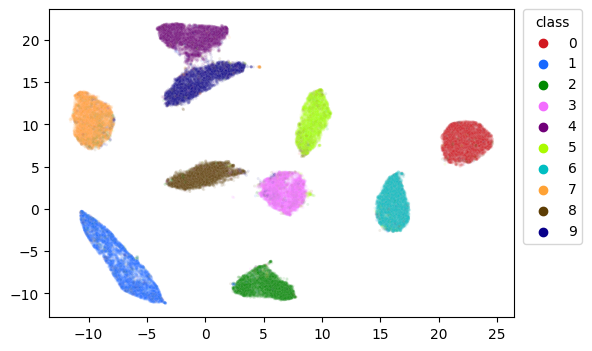

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6068142857142858, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.32656378749929976, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.12446285714285717, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.18786, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2711902857142858, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 46.8 s (started: 2022-11-26 19:02:34 -08:00)


In [12]:
pl.standard_eval(
    [
        pl.embedder("htumap", params=dict(a=1, b=1)),
        pl.embedder("htumap", params=dict(a=0.5, b=1)),
    ],
    dataset="mnist",
)

Still some 5s stuck with the 3s, but the 8s are now better.

Setting `a=1000` should give an SNE-like result:

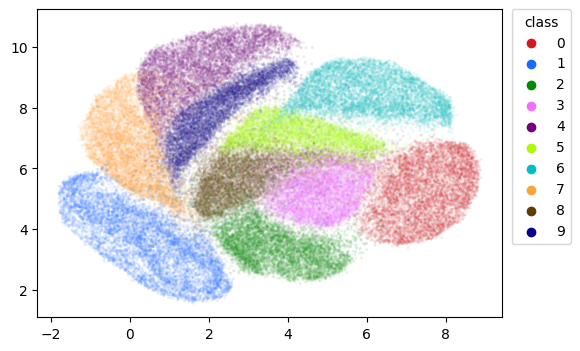

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6358257142857143, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.407005207787889, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.058853333333333334, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.10873342857142858, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.18149885714285716, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 32.9 s (started: 2022-11-26 18:55:44 -08:00)


In [5]:
pl.standard_eval(method="htumap", params=dict(a=1000, b=1), dataset="mnist")